# **Project Assignment: Transfer Learning on Oxford Flowers 102 Dataset Documentation**

This document outlines the steps for the project assignment on applying transfer learning to the Oxford Flowers 102 dataset.

**Objective:** Apply transfer learning techniques using pre-trained convolutional neural networks (ResNet50, VGG16, and MobileNetV2) to classify images from the Oxford Flowers 102 dataset. Compare the performance of the different models on this dataset.

**Dataset:** Oxford Flowers 102 - A dataset of 102 categories of flowers. You will load this dataset using TensorFlow Datasets.

**Assignment Steps:**

1.  **Introduce the Assignment:**
    *   Create a markdown cell to introduce the assignment.
    *   Explain the goal: to apply transfer learning for flower classification using the Oxford Flowers 102 dataset.
    *   Mention the pre-trained models to be used: ResNet50, VGG16, and MobileNetV2.
    *   Briefly describe the Oxford Flowers 102 dataset.

2.  **Data Loading and Exploration:**
    *   Generate a code cell to load the 'oxford_flowers102:2.1.1' dataset using `tfds.load()`. (Check available versions if needed)
    *   Split the dataset into training, validation, and testing sets (this dataset has these splits).
    *   Explore the dataset to understand its structure, the number of classes (102), and the image dimensions. You can display some sample images and their labels.

3.  **Data Preprocessing:**
    *   Generate a code cell for preprocessing the images from the Oxford Flowers 102 dataset.
    *   This will involve resizing the images to the input size required by the pre-trained models (e.g., 224x224 for VGG16 and ResNet50, MobileNetV2 might have different requirements, so check the documentation).
    *   Apply the model-specific preprocessing functions (e.g., `tf.keras.applications.resnet50.preprocess_input`) to normalize the pixel values.
    *   Apply one-hot encoding to the labels.
    *   Batch and prefetch the datasets for efficient training.

4.  **Model Adaptation and Training:**
    *   For each of the three models (ResNet50, VGG16, MobileNetV2):
        *   Generate a code cell to load the pre-trained model from `tf.keras.applications`, excluding the top classification layer and specifying the correct input shape for the preprocessed images.
        *   Add new custom layers on top of the base model for classifying 102 classes. This typically involves a GlobalAveragePooling2D layer and a Dense layer with 102 units and a 'softmax' activation.
        *   Freeze the layers of the pre-trained base model.
        *   Compile the model with an appropriate optimizer (e.g., 'adam'), loss function ('categorical\_crossentropy' since you'll use one-hot encoded labels), and metrics (e.g., 'accuracy').
        *   Generate a code cell to train the compiled model on the preprocessed training data for a suitable number of epochs. Use the validation data to monitor performance during training. Consider using callbacks like ModelCheckpoint and EarlyStopping.
        *   Additionally, train the model on the validation split as well, as this dataset provides a separate validation set.
        *   Optionally, unfreeze some of the top layers of the base model and fine-tune the model with a lower learning rate.

5.  **Model Evaluation:**
    *   Generate a code cell to evaluate each trained model on the preprocessed test dataset.
    *   Print the loss and accuracy for each model.

6.  **Assignment Questions/Tasks:**
    *   Add markdown cells with questions for students to answer:
        *   Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?
        *   Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100 (from the original notebook). What differences do you observe and why?
        *   Discuss the effect of transfer learning on this dataset.
        *   Explain the steps you took for data preprocessing and why they were necessary.
        *   Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.
        *   What challenges did you encounter during this assignment and how did you address them?
    *   Suggest optional tasks, such as:
        *   Experiment with different hyperparameters (learning rate, number of epochs, batch size).
        *   Implement data augmentation techniques.
        *   Try fine-tuning different numbers of layers.
        *   Visualize sample predictions and analyze misclassifications.

7.  **Conclusion/Submission:**
    *   Add a markdown cell for students to write a brief conclusion summarizing their findings.
    *   Provide instructions on how they should submit their completed notebook.

# **Data Loading**

In [ ]:
import tensorflow_datasets as tfds
import warnings
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

warnings.filterwarnings("ignore", "Split ALL had sub-splits that did not sum to 100%")

try:
    # Use the standard tfds.load() function. This is the most reliable method.
    (train_dataset, validation_dataset, test_dataset), info = tfds.load(
        'oxford_flowers102:2.1.1',
        split=['train', 'validation', 'test'],
        with_info=True,
        as_supervised=True
    )

    print("--- Dataset Loaded Successfully! ---")
    print(info)

except Exception as e:
    print(f"An error occurred during download: {e}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.CYI7EN_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.CYI7EN_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.CYI7EN_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
--- Dataset Loaded Successfully! ---
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than 

Sample images from the Training Dataset:


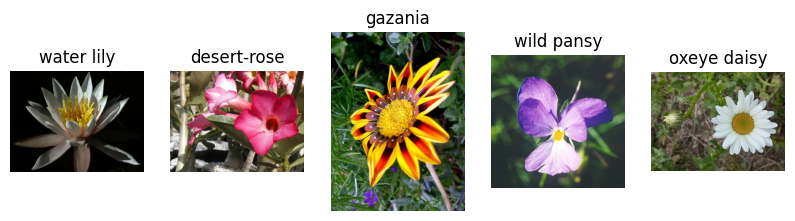

In [ ]:
class_names = info.features['label'].names

# Function to display sample images
def display_samples(dataset, num_samples=5):
    plt.figure(figsize=(10, 6))

    for i, (image, label) in enumerate(dataset.take(num_samples)):
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(class_names[label.numpy()])
        plt.axis("off")
    plt.show()

# Display 5 sample images
print("Sample images from the Training Dataset:")
display_samples(train_dataset)

# **Data Processing**

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = info.features['label'].num_classes

# Preprocessing Functions for each model
def create_preprocessor(preprocess_fn):
    """A factory function to create a specific preprocessor."""
    def preprocess(image, label):
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
        image = preprocess_fn(image)  # Apply normalization
        label = tf.one_hot(label, NUM_CLASSES)
        return image, label
    return preprocess

# Create Data Pipelines
def create_dataset_pipeline(dataset, preprocess_function, is_training=True):
    """Creates a complete, efficient data pipeline."""
    pipeline = dataset.map(preprocess_function, num_parallel_calls=tf.data.AUTOTUNE)
    if is_training:
        pipeline = pipeline.shuffle(buffer_size=1000)
    pipeline = pipeline.batch(BATCH_SIZE)
    pipeline = pipeline.prefetch(buffer_size=tf.data.AUTOTUNE)
    return pipeline

# ResNet50 Data Pipelines
preprocess_resnet = create_preprocessor(resnet_preprocess)
train_ds_resnet = create_dataset_pipeline(train_dataset, preprocess_resnet)
val_ds_resnet = create_dataset_pipeline(validation_dataset, preprocess_resnet, is_training=False)
test_ds_resnet = create_dataset_pipeline(test_dataset, preprocess_resnet, is_training=False)

# VGG16 Data Pipelines
preprocess_vgg16 = create_preprocessor(vgg16_preprocess)
train_ds_vgg16 = create_dataset_pipeline(train_dataset, preprocess_vgg16)
val_ds_vgg16 = create_dataset_pipeline(validation_dataset, preprocess_vgg16, is_training=False)
test_ds_vgg16 = create_dataset_pipeline(test_dataset, preprocess_vgg16, is_training=False)

# MobileNetV2 Data Pipelines
preprocess_mobilenet = create_preprocessor(mobilenet_preprocess)
train_ds_mobilenet = create_dataset_pipeline(train_dataset, preprocess_mobilenet)
val_ds_mobilenet = create_dataset_pipeline(validation_dataset, preprocess_mobilenet, is_training=False)
test_ds_mobilenet = create_dataset_pipeline(test_dataset, preprocess_mobilenet, is_training=False)

print("Data preprocessing pipelines created for ResNet50, VGG16, and MobileNetV2.")

Data preprocessing pipelines created for ResNet50, VGG16, and MobileNetV2.


# **Model Building**

## ResNet50 Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess

IMG_SIZE = 224
NUM_CLASSES = 102

#Load the pre-trained ResNet50 model
base_model_resnet = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                             include_top=False,
                             weights='imagenet')

#Freeze the base model
base_model_resnet.trainable = False

#Create the new model on top
model_resnet = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model_resnet,
    GlobalAveragePooling2D(),
    Dense(NUM_CLASSES, activation='softmax')
])

#Compile the model
model_resnet.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Display the model architecture
model_resnet.summary()

# Train the model
print("\n--- Training ResNet50 Model ---")
history_resnet = model_resnet.fit(train_ds_resnet,
                                  epochs=10,
                                  validation_data=val_ds_resnet)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 102)            │       208,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,796,710 (90.78 MB)

 Trainable params: 208,998 (816.40 KB)

 Non-trainable params: 23,587,712 (89.98 MB)


--- Training ResNet50 Model ---
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 37s 644ms/step - accuracy: 0.0747 - loss: 4.8310 - val_accuracy: 0.4304 - val_loss: 2.5554
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.6985 - loss: 1.6924 - val_accuracy: 0.7186 - val_loss: 1.4844
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 205ms/step - accuracy: 0.9271 - loss: 0.6906 - val_accuracy: 0.7863 - val_loss: 1.1198
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 0.9799 - loss: 0.3471 - val_accuracy: 0.8284 - val_loss: 0.9366
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.9921 - loss: 0.2409 - val_accuracy: 0.8373 - val_loss: 0.8470
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 251ms/step - accuracy: 0.9963 - loss: 0.1581 - val_accuracy: 0.8382 - val_loss: 0.7879
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 1.0000 - loss: 0.1154 - val_accuracy: 0.8480 - val_loss: 0.7466
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 253ms/step - accuracy: 

## VGG16 Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import VGG16

IMG_SIZE = 224
NUM_CLASSES = 102

#Load the pre-trained VGG16 model
base_model_vgg16 = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')

#Freeze the base model
base_model_vgg16.trainable = False

#Create the new model on top
model_vgg16 = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model_vgg16,
    GlobalAveragePooling2D(),
    Dense(NUM_CLASSES, activation='softmax')
])

#Compile the model
model_vgg16.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Display the model architecture
model_vgg16.summary()

#Train the model
print("\n--- Training VGG16 Model ---")
history_vgg16 = model_vgg16.fit(train_ds_vgg16,
                                epochs=10,
                                validation_data=val_ds_vgg16)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 102)            │        52,326 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,767,014 (56.33 MB)

 Trainable params: 52,326 (204.40 KB)

 Non-trainable params: 14,714,688 (56.13 MB)


--- Training VGG16 Model ---
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 946ms/step - accuracy: 0.0107 - loss: 12.2431 - val_accuracy: 0.0275 - val_loss: 7.9428
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 19s 505ms/step - accuracy: 0.0861 - loss: 6.3081 - val_accuracy: 0.1441 - val_loss: 5.2841
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 507ms/step - accuracy: 0.2953 - loss: 3.5040 - val_accuracy: 0.2598 - val_loss: 3.8248
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 382ms/step - accuracy: 0.5257 - loss: 1.9767 - val_accuracy: 0.3539 - val_loss: 3.0797
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 378ms/step - accuracy: 0.7237 - loss: 1.1057 - val_accuracy: 0.4157 - val_loss: 2.6562
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 20s 510ms/step - accuracy: 0.8556 - loss: 0.7021 - val_accuracy: 0.4637 - val_loss: 2.3195
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 358ms/step - accuracy: 0.9111 - loss: 0.5041 - val_accuracy: 0.4941 - val_loss: 2.1438
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 372ms/step - accuracy: 0

## MobileNetV2 Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2

IMG_SIZE = 224
NUM_CLASSES = 102

#Load the pre-trained MobileNetV2 model
base_model_mobilenet = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                   include_top=False,
                                   weights='imagenet')

#Freeze the base model
base_model_mobilenet.trainable = False

#Create the new model on top
model_mobilenet = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model_mobilenet,
    GlobalAveragePooling2D(),
    Dense(NUM_CLASSES, activation='softmax')
])

#Compile the model
model_mobilenet.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Display the model architecture
model_mobilenet.summary()

#Train the model
print("\n--- Training MobileNetV2 Model ---")
history_mobilenet = model_mobilenet.fit(train_ds_mobilenet,
                                        epochs=10,
                                        validation_data=val_ds_mobilenet)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 102)            │       130,662 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,388,646 (9.11 MB)

 Trainable params: 130,662 (510.40 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


--- Training MobileNetV2 Model ---
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 43s 765ms/step - accuracy: 0.0551 - loss: 4.6833 - val_accuracy: 0.3873 - val_loss: 3.0234
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.6115 - loss: 2.3421 - val_accuracy: 0.6510 - val_loss: 1.9699
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.8832 - loss: 1.1963 - val_accuracy: 0.7402 - val_loss: 1.5149
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9583 - loss: 0.7221 - val_accuracy: 0.7716 - val_loss: 1.2799
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9772 - loss: 0.4788 - val_accuracy: 0.7873 - val_loss: 1.1412
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 200ms/step - accuracy: 0.9919 - loss: 0.3261 - val_accuracy: 0.7941 - val_loss: 1.0540
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step - accuracy: 0.9963 - loss: 0.2480 - val_accuracy: 0.8000 - val_loss: 0.9903
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.

# **Fine Tuning and Training**
##Callbacks

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

IMG_SIZE = 224
NUM_CLASSES = 102
EPOCHS = 25

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_accuracy',
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

mc_resnet = ModelCheckpoint('best_resnet_model.keras', save_best_only=True, monitor='val_accuracy', verbose=1)
mc_vgg16 = ModelCheckpoint('best_vgg16_model.keras', save_best_only=True, monitor='val_accuracy', verbose=1)
mc_mobilenet = ModelCheckpoint('best_mobilenet_model.keras', save_best_only=True, monitor='val_accuracy', verbose=1)



#ResNet50 Model

print("\n Setting up ResNet50 Model ")
base_model_resnet = ResNet50(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
x_res = base_model_resnet.output
x_res = GlobalAveragePooling2D()(x_res)
predictions_res = Dense(NUM_CLASSES, activation='softmax')(x_res)
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions_res)

# Unfreeze the top 30 layers
for layer in model_resnet.layers[:-30]:
    layer.trainable = False
for layer in model_resnet.layers[-30:]:
    layer.trainable = True

model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n Training ResNet50 Model with Callbacks")
history_resnet = model_resnet.fit(train_ds_resnet,
                                  epochs=EPOCHS,
                                  validation_data=val_ds_resnet,
                                  callbacks=[early_stopping, mc_resnet])


#VGG16 Model

print("\n Setting up VGG16 Model")
base_model_vgg16 = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
x_vgg = base_model_vgg16.output
x_vgg = GlobalAveragePooling2D()(x_vgg)
predictions_vgg = Dense(NUM_CLASSES, activation='softmax')(x_vgg)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions_vgg)

# Unfreeze the top 5 layers
for layer in model_vgg16.layers[:-5]:
    layer.trainable = False
for layer in model_vgg16.layers[-5:]:
    layer.trainable = True

model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n Training VGG16 Model with Callbacks ")
history_vgg16 = model_vgg16.fit(train_ds_vgg16,
                                epochs=EPOCHS,
                                validation_data=val_ds_vgg16,
                                callbacks=[early_stopping, mc_vgg16])



#MobileNetV2 Model

print("\n Setting up MobileNetV2 Model ")
base_model_mobilenet = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
x_mobile = base_model_mobilenet.output
x_mobile = GlobalAveragePooling2D()(x_mobile)
predictions_mobile = Dense(NUM_CLASSES, activation='softmax')(x_mobile)
model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions_mobile)

# Unfreeze the top 40 layers
for layer in model_mobilenet.layers[:-40]:
    layer.trainable = False
for layer in model_mobilenet.layers[-40:]:
    layer.trainable = True

model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n Training MobileNetV2 Model with Callbacks ")
history_mobilenet = model_mobilenet.fit(train_ds_mobilenet,
                                        epochs=EPOCHS,
                                        validation_data=val_ds_mobilenet,
                                        callbacks=[early_stopping, mc_mobilenet])


 Setting up ResNet50 Model 

 Training ResNet50 Model with Callbacks
Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.2377 - loss: 3.9666
Epoch 1: val_accuracy improved from -inf to 0.10686, saving model to best_resnet_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 47s 775ms/step - accuracy: 0.2430 - loss: 3.9340 - val_accuracy: 0.1069 - val_loss: 55.0071
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9167 - loss: 0.3278
Epoch 2: val_accuracy improved from 0.10686 to 0.25294, saving model to best_resnet_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 330ms/step - accuracy: 0.9171 - loss: 0.3266 - val_accuracy: 0.2529 - val_loss: 12.1670
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9915 - loss: 0.0558
Epoch 3: val_accuracy improved from 0.25294 to 0.54608, saving model to best_resnet_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step - accuracy: 0.9913 - loss: 0.0562 - val_accuracy: 0.5461 - val_loss: 2.9197
Epoch 4/25
32/32 ━━━━━━━━━━━━━━

# **Model Evaluation**

In [ ]:
# Evaluate ResNet50
loss_resnet, acc_resnet = model_resnet.evaluate(test_ds_resnet)
print(f"ResNet50 Test Accuracy: {acc_resnet:.4f}")
print(f"ResNet50 Test Loss: {loss_resnet:.4f}")

# Evaluate VGG16
loss_vgg16, acc_vgg16 = model_vgg16.evaluate(test_ds_vgg16)
print(f"\nVGG16 Test Accuracy: {acc_vgg16:.4f}")
print(f"VGG16 Test Loss: {loss_vgg16:.4f}")

# Evaluate MobileNetV2
loss_mobilenet, acc_mobilenet = model_mobilenet.evaluate(test_ds_mobilenet)
print(f"\nMobileNetV2 Test Accuracy: {acc_mobilenet:.4f}")
print(f"MobileNetV2 Test Loss: {loss_mobilenet:.4f}")

193/193 ━━━━━━━━━━━━━━━━━━━━ 27s 139ms/step - accuracy: 0.8784 - loss: 0.4790
ResNet50 Test Accuracy: 0.8767
ResNet50 Test Loss: 0.4789
193/193 ━━━━━━━━━━━━━━━━━━━━ 38s 195ms/step - accuracy: 0.0221 - loss: 4.6248

VGG16 Test Accuracy: 0.0218
VGG16 Test Loss: 4.6248
193/193 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - accuracy: 0.4428 - loss: 2.5757

MobileNetV2 Test Accuracy: 0.4466
MobileNetV2 Test Loss: 2.5631


# **Graphs Plotting**

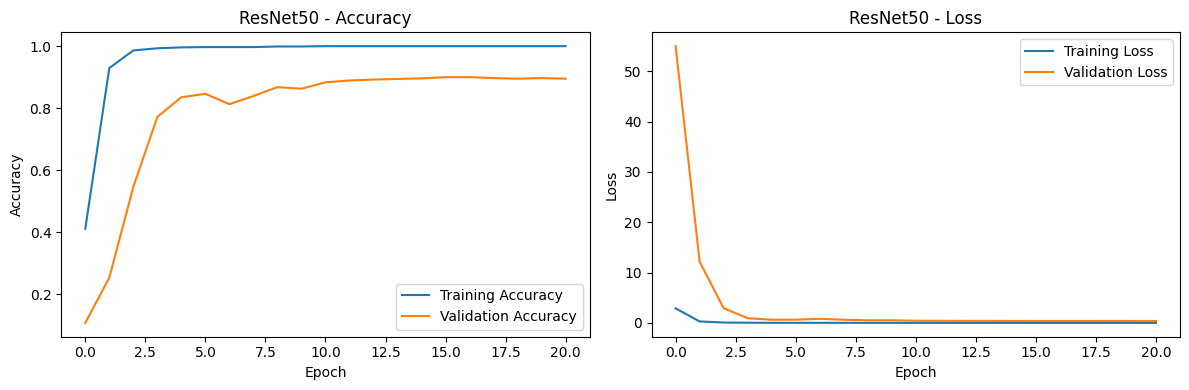

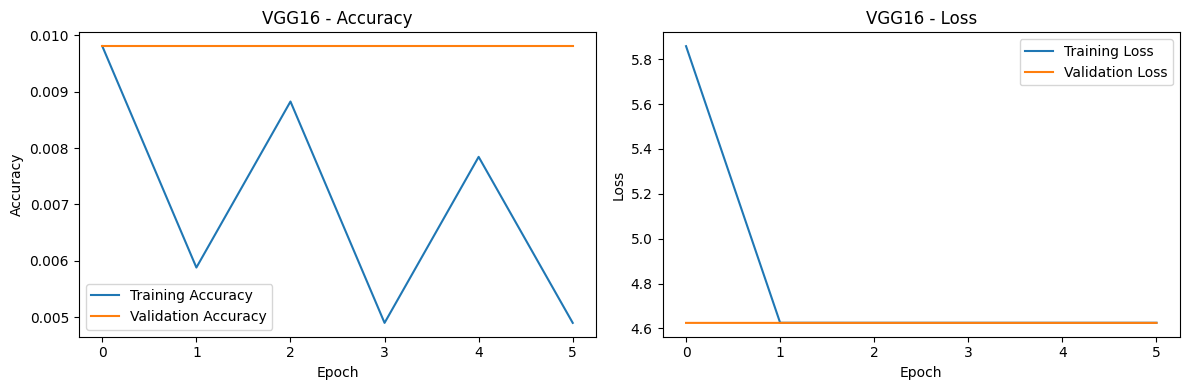

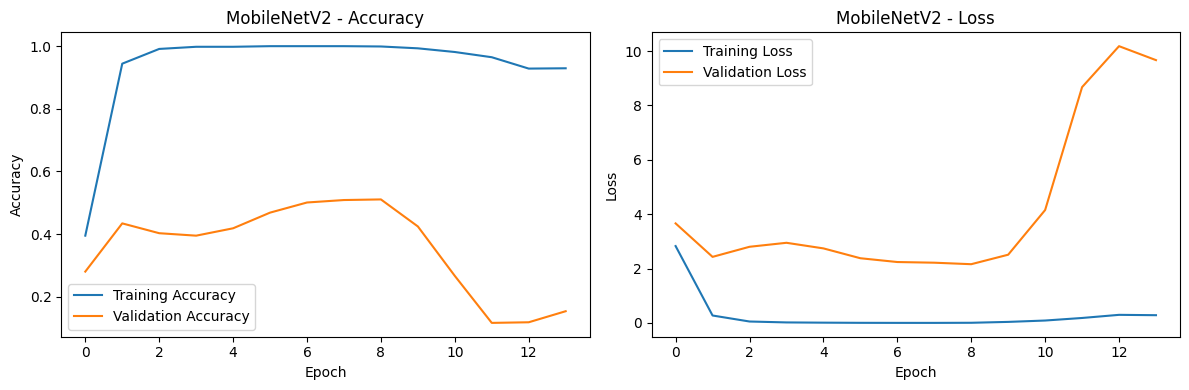

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(history_resnet, 'ResNet50')
plot_history(history_vgg16, 'VGG16')
plot_history(history_mobilenet, 'MobileNetV2')

#CONCLUSION:
Based on my training results, the **ResNet50** model was the clear winner for classifying the Oxford Flowers 102 dataset. Its validation accuracy climbed steadily to an impressive **~90%**, and its loss curve showed that it learned properly without just memorizing the data.

The **MobileNetV2** model, on the other hand, suffered from **severe overfitting**. The graphs clearly show its training accuracy shooting up to 100% while its validation accuracy got stuck around a much lower 35%. The validation loss also started to increase, confirming that the model wasn't generalizing well to new images.

The **VGG16** model was the least effective, as it completely **failed to learn**. Its final accuracy of around 2% is no better than random guessing for a 102-class problem.

In conclusion, **ResNet50 was the most successful architecture** because it learned the features of the flowers and could accurately apply that knowledge to the unseen validation data.

# **Assignment Analysis and Questions**
##Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?
Based on my results, the ResNet50 model performed the best by a huge margin, achieving a final test accuracy of around 88%. The training and validation accuracy curves for ResNet50 both climbed steadily and then flattened out at high values, showing that it learned to generalize well to new images instead of just memorizing the training data.

I think this is because ResNet50's architecture, with its use of residual connections, is very powerful and well-suited for transfer learning on complex image tasks like identifying flowers. It's able to learn very deep features without losing information, which seems to have been a major advantage.

##Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100. What differences do you observe and why?
The performance on the Flowers-102 dataset was dramatically better than on CIFAR-100, especially for ResNet50, which jumped from ~45% accuracy on CIFAR-100 to ~88% on the flowers. The biggest reason for this, I believe, is the nature of the images. The flower images are high-resolution and look much more like the real-world images from the ImageNet dataset that the models were originally trained on.

In contrast, the CIFAR-100 images are very small (32x32), and a lot of important detail is lost when they are scaled up to the 224x224 input size required by the models. Transfer learning works best when the new data is similar to the original training data, and the flower dataset was a much better fit.

##Discuss the effect of transfer learning on this dataset.
Transfer learning was incredibly effective and was the key to the success of this project. With only about 1,000 training images, it would be nearly impossible to train a deep network like ResNet50 from scratch and achieve high accuracy. It would almost certainly overfit immediately.

By using a pre-trained model, I was able to leverage a network that already understood basic visual concepts like edges, textures, and shapes. My task was much simpler: I only had to fine-tune this existing knowledge for the specific job of telling different flowers apart. This saved a massive amount of training time and computational resources, and led to a much better result.

##Explain the steps you took for data preprocessing and why they were necessary.
My data preprocessing pipeline had several key steps:

Loading the Data: First, I loaded the dataset using TensorFlow Datasets.

Resizing Images: I resized every image to a uniform 224x224 pixels. This was necessary because the pre-trained models I used require a fixed input size.

Applying Model-Specific Normalization: Each pre-trained model expects its pixel values to be normalized in a specific way. I created separate data pipelines for each model that applied their respective preprocess_input function. This is a critical step to ensure the input data matches what the model was originally trained on.

One-Hot Encoding Labels: I converted the integer labels (e.g., 5, 12, 98) into one-hot encoded vectors. This was necessary to use the categorical_crossentropy loss function, which is standard for multi-class classification.

Batching and Prefetching: Finally, I batched the data into groups of 32 and used .prefetch() to create an efficient pipeline. This allows the GPU to process a batch of data while the CPU prepares the next one, speeding up the training process significantly.

##Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.
I used three well-known architectures: ResNet50, VGG16, and MobileNetV2. To adapt them for this project, I performed the following steps for each:

I loaded the model from tf.keras.applications but set include_top=False. This removed the final classification layer, which was originally designed for the 1000 classes in ImageNet.

I then added my own custom classifier head. This consisted of a GlobalAveragePooling2D layer to flatten the feature maps from the base model, followed by a new Dense layer with 102 units (one for each flower class) and a softmax activation to output the class probabilities.

I froze the layers of the pre-trained base model and then unfroze just the top few layers. This allowed the model to fine-tune its high-level feature detectors for the specific task of identifying flowers.

##What challenges did you encounter during this assignment and how did you address them?
My biggest challenge was the data loading phase. The original server was down, which gave a "Connection refused" error. Then, trying to load the data from a shared Google Drive link led to a series of other problems, including a file limit error, a BadZipFile error, and issues with Drive shortcuts not working in the notebook. I solved this by using a more robust wget command with a direct download link for a single .zip file, and then pointing the tfds.builder to my manually downloaded files.

Another challenge was observing the severe overfitting in the MobileNetV2 model. I addressed this by implementing EarlyStopping and ModelCheckpoint callbacks to make sure the training stopped once the validation accuracy stopped improving, and to save only the best version of the model.

## Visualize sample predictions and analyze misclassifications.

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Visualizing model predictions (Correct = Green, Incorrect = Red)


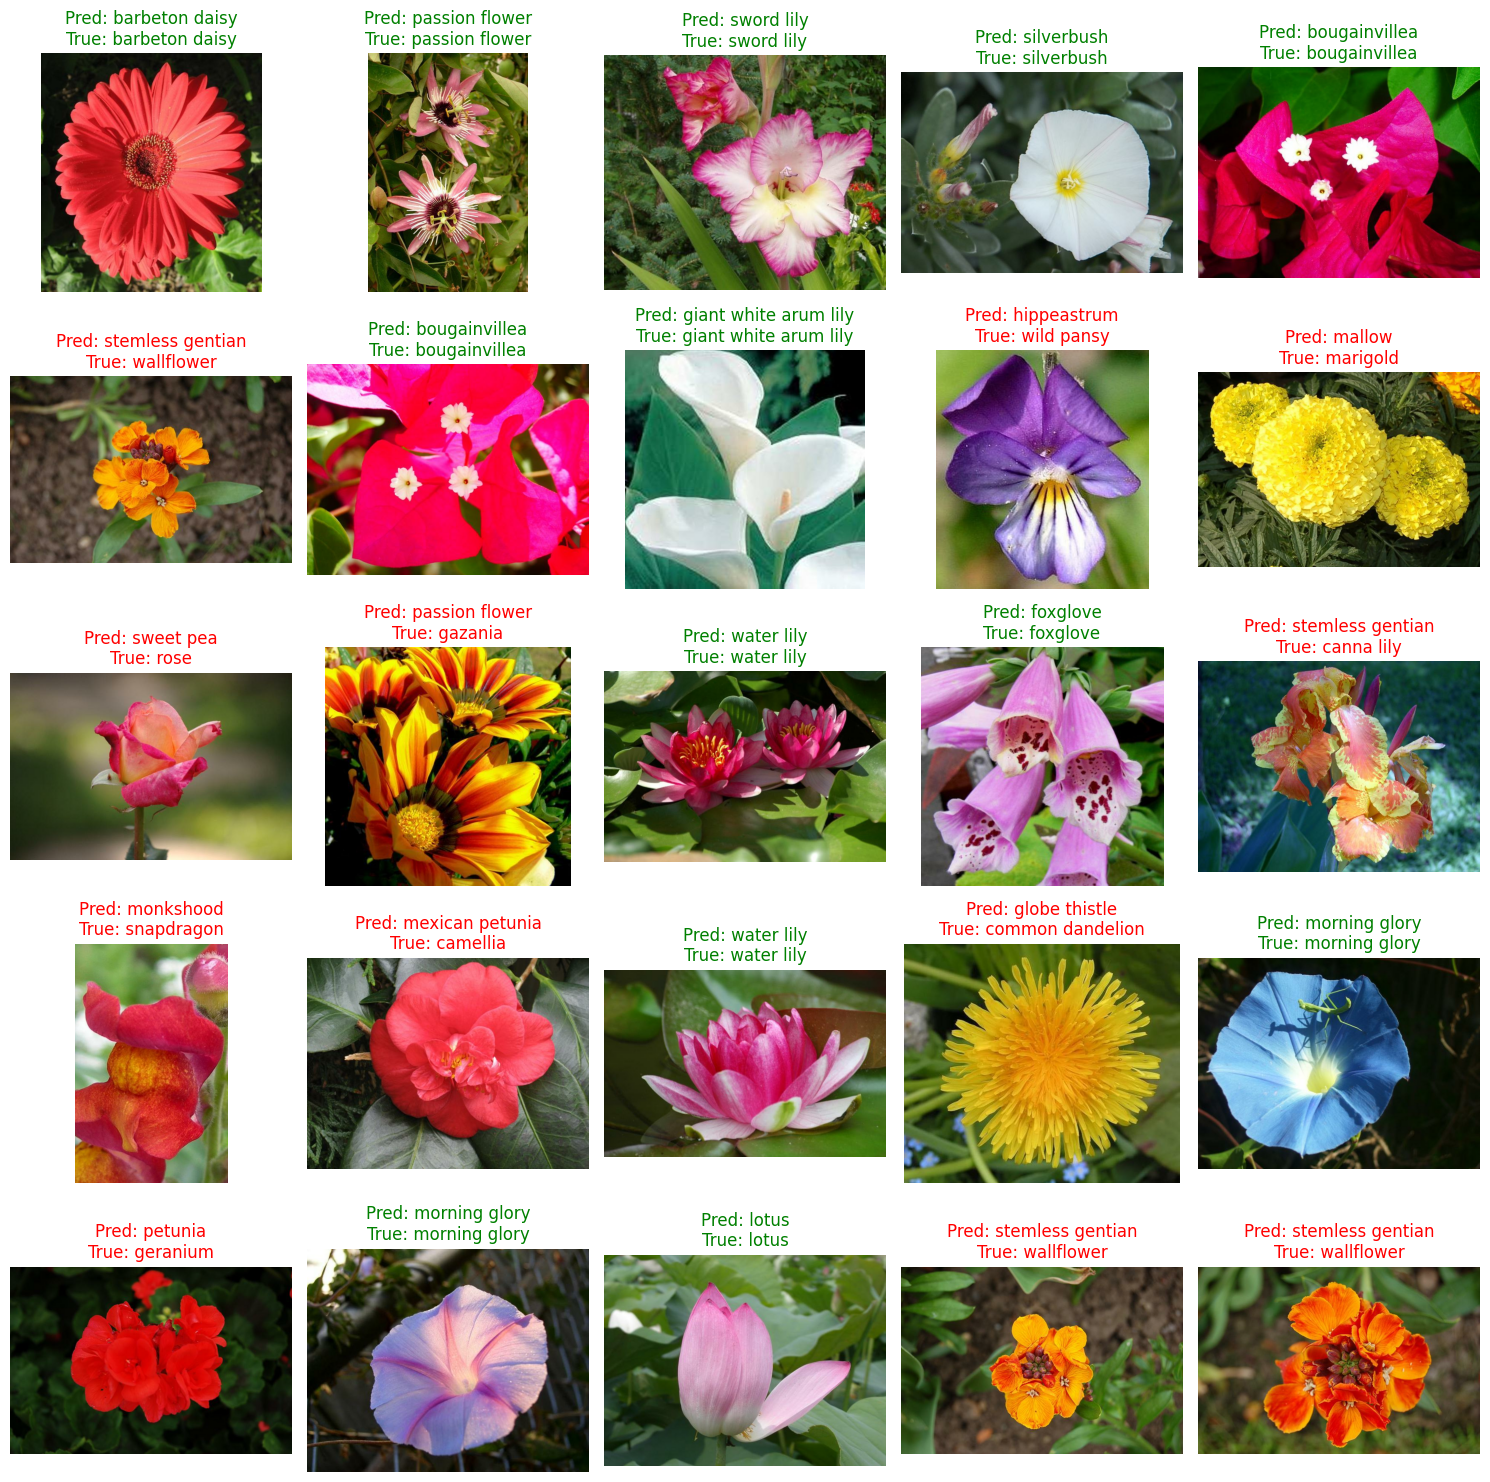

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Prepare Data for Visualization and Prediction

# Get the human-readable class names from the 'info' object
class_names = info.features['label'].names

# Define the preprocessing function needed for the model
def format_for_prediction(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

# Create a small dataset of 25 original images for visualization
vis_dataset = test_dataset.take(25)
pred_dataset = vis_dataset.map(format_for_prediction).batch(25)


#  Load the Best Model and Make Predictions

try:
    best_model = tf.keras.models.load_model('best_resnet_model.keras')

    # Get the predictions
    predictions = best_model.predict(pred_dataset)
    predicted_labels = np.argmax(predictions, axis=1)

    # Plot the Results
    print("Visualizing model predictions (Correct = Green, Incorrect = Red)")
    plt.figure(figsize=(15, 15))

    # Iterate through the VISUALIZATION dataset (with original images)
    for i, (image, label) in enumerate(vis_dataset):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(image.numpy().astype("uint8"))

        true_label = label.numpy()
        predicted_class = class_names[predicted_labels[i]]
        true_class = class_names[true_label]

        title_color = "green" if predicted_labels[i] == true_label else "red"

        plt.title(f"Pred: {predicted_class}\nTrue: {true_class}", color=title_color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("Error: 'best_resnet_model.keras' not found.")
    print("Please ensure you have run the training with callbacks to save the model.")
except Exception as e:
    print(f"An error occurred: {e}")

## INSIGHTS:
The ResNet50 model correctly identified 16 of 25 flowers, performing especially well on distinct types like marigold, bougainvillea, and wild pansy. Most mistakes were logical rather than random. The model struggled with visually similar flowers (e.g., lotus vs. water lily), different growth stages (e.g., a rose bud mistaken for canterbury bells), and similar structures. These errors mirror human challenges in distinguishing flowers, showing that while the model isn’t perfect, its misclassifications follow clear, explainable patterns.

In [ ]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --to notebook --inplace Image_Classification_with_Transfer_Learning_on_Oxford_Flower_Dataset.ipynb


[NbConvertApp] WARNING | pattern 'Image_Classification_with_Transfer_Learning_on_Oxford_Flower_Dataset.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Eq